In [1]:
import os
os.chdir('../../src')

In [24]:
import matplotlib.pyplot as plt
import torch
from transformer.models import Transformer
from utils import plot_polygon
from data import PolygonSentenceReader, Polygon

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_dim = 1
y_dim = 1

# Reconstruct the Transformer model and load the trained checkpoint
model = Transformer(x_dim, y_dim)
checkpoint_path = "../final_model.pt"  # Change if the checkpoint is saved elsewhere
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Put model in evaluation mode
model.to(device)

Transformer(
  (project_r): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [27]:
MASK_TOKEN = -1.0
EOS_TOKEN = -2.0
batch_size = 8
max_num_context = 9

polygon_reader = PolygonSentenceReader(
    batch_size=batch_size,
    max_num_context=max_num_context,
    max_seq_len=256,
    min_num_sides=3,
    max_num_sides=3,
    testing=True,
)

In [29]:
def evaluate_context_size_error(num_context, plot_polygons=False):
    """
    For a given number of context examples, generate a few-shot batch,
    run the transformer on the concatenated prompt (without string conversion),
    and compute the average absolute error on the masked target tokens.

    Returns
    -------
      avg_error: float 
        the average absolute error over all masked target tokens in the batch.
    """    
    (
        context_x,
        context_y,
        target_x,
        target_y,
        total_tokens_list,
        true_target_polygons,
        max_seq_len,
        num_context,
    ) = polygon_reader.generate_polygon_batch_few_shot_completion_task()

    batch_size = context_x.shape[0]

    prompt_tokens_list = []    # list of token lists, one per sample
    prompt_mlm_mask_list = []   # corresponding MLM mask list for each token in the prompt
    context_lengths = []        # number of tokens from all context examples in each sample
    target_lengths = []         # effective length of target tokens (after trimming)

    for i in range(batch_size):
        sample_prompt = []  # will hold tokens for sample i
        sample_mask = []    # will hold MLM mask tokens (0 for context; for target: 1 if token equals MASK_TOKEN)
        
        # Process each context example
        total_context_length = 0
        for j in range(num_context):
            tokens = context_x[i, j].tolist()  # context tokens for sample i, context j
            # Remove trailing pad tokens (assumed to be 0.0)
            while tokens and tokens[-1] == 0.0:
                tokens.pop()
            sample_prompt.extend(tokens)
            # For context tokens, the MLM mask is all zeros because they are fully observed.
            sample_mask.extend([0] * len(tokens))
            total_context_length += len(tokens)
            # Same for context_y
            tokens = context_y[i, j].tolist()
            while tokens and tokens[-1] == 0.0:
                tokens.pop()
            sample_prompt.extend(tokens)
            sample_mask.extend([0] * len(tokens))
            sample_prompt.append(EOS_TOKEN) # add EOS token
            sample_mask.append(0)
            total_context_length += (len(tokens) + 1)
        context_lengths.append(total_context_length)
        
        # Process the target polygon tokens
        target_tokens = target_x[i, 0].tolist()
        # Remove trailing pad tokens from the target sequence as well.
        while target_tokens and target_tokens[-1] == 0.0:
            target_tokens.pop()
        target_lengths.append(len(target_tokens))
        # For the target tokens, set mask=1 if the token equals MASK_TOKEN, else 0.
        target_mlm_mask = [1 if token == MASK_TOKEN else 0 for token in target_tokens]
        
        # Append target tokens and their MLM mask to the sample prompt.
        sample_prompt.extend(target_tokens)
        sample_mask.extend(target_mlm_mask)
        
        prompt_tokens_list.append(sample_prompt)
        prompt_mlm_mask_list.append(sample_mask)

    padded_prompts = [tokens + [0.0] * (max_seq_len - len(tokens))
                    for tokens in prompt_tokens_list]
    padded_mlm_masks = [mask + [0] * (max_seq_len - len(mask))
                        for mask in prompt_mlm_mask_list]

    # Convert to tensors
    prompt_tokens_tensor = torch.tensor(padded_prompts, dtype=torch.float32)
    prompt_mlm_mask_tensor = torch.tensor(padded_mlm_masks, dtype=torch.float32)

    # Create an attention mask that marks non-padding tokens (non 0.0 entries)
    prompt_attention_mask = (prompt_tokens_tensor != 0.0).float()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    prompt_tokens_tensor = prompt_tokens_tensor.to(device)
    prompt_mlm_mask_tensor = prompt_mlm_mask_tensor.to(device)
    prompt_attention_mask = prompt_attention_mask.to(device)

    with torch.no_grad():
        output = model(
            prompt_tokens_tensor,
            mlm_mask=prompt_mlm_mask_tensor,
            attention_mask=prompt_attention_mask,
        )
        predictions = output.get("logits", None)

    if predictions is None:
        print("No predictions returned by the model. Please verify the output structure.")
    else:
        # Replace Masked Tokens in the Target Portion for Each Sample
        # For each sample, the target portion starts right after its context tokens.
        completed_prompts = prompt_tokens_tensor.clone()  # copy of the input prompt
        for i in range(batch_size):
            # Calculate the start index of the target portion in this sample.
            target_start = context_lengths[i]
            # The target portion occupies the remaining tokens for this sample.
            # Create a boolean mask for the target region where original mask is 1.
            sample_target_mask = torch.tensor(prompt_mlm_mask_list[i][target_start:], dtype=torch.bool, device=device)
            # Replace only the masked positions in the target region with predictions.
            target_region_indices = torch.arange(target_start, target_start + len(prompt_tokens_list[i]) - context_lengths[i], device=device)
            # Use the MLM mask to decide replacement positions.
            completed_prompts[i, target_region_indices[sample_target_mask]] = predictions[i, target_region_indices[sample_target_mask]]
        
        # Evaluate the Predictions on Target Tokens
        total_error = 0.0
        total_count = 0
        for i in range(batch_size):
            # Extract the target portion (trimmed) for sample i from the completed prompt.
            start = context_lengths[i]
            end = start + target_lengths[i]
            pred_target = completed_prompts[i, start:end].tolist()
            # Use the ground truth for the target polygon, trimmed of padding.
            true_target = target_y[i, 0].tolist()
            while true_target and true_target[-1] == 0.0:
                true_target.pop()
            # Use the original target mask to know which positions were predicted.
            orig_mask = [1 if token == MASK_TOKEN else 0 for token in target_x[i, 0].tolist()]
            for j, masked in enumerate(orig_mask):
                if masked:
                    if j < len(true_target):
                        total_error += abs(pred_target[j] - true_target[j])
                        total_count += 1
        avg_error = total_error / total_count if total_count > 0 else float('nan')
        print("Average absolute error on target tokens:", avg_error)
        
        # Reconstruct and Visualise the Predicted Polygons
        if plot_polygons:
            for i in range(batch_size):
                effective_length = total_tokens_list[i]
                start = context_lengths[i]
                # Use the effective target token length to reconstruct the polygon.
                pred_target_tokens = completed_prompts[i, start:start + effective_length].tolist()
                try:
                    print("True Polygon for sample {}: {}".format(i, true_target_polygons[i].to_tokenised()))
                    pred_polygon = Polygon.from_tokenised(pred_target_tokens)
                    print("Predicted Polygon for sample {}: {}".format(i, pred_polygon))
                    plot_polygon(true_target_polygons[i].vertices, title="True Polygon for sample {}".format(i))
                    plot_polygon(pred_polygon.vertices, title="Predicted Polygon for sample {}".format(i))
                except Exception as e:
                    print("Error constructing polygon for sample {}: {}".format(i, e))
    
    return avg_error

Evaluating for Context Size = 1
cuda
Average absolute error on target tokens: 26.722508849948646
  Average absolute error: 26.7225
Evaluating for Context Size = 2
cuda
Average absolute error on target tokens: 19.832662469521164
  Average absolute error: 19.8327
Evaluating for Context Size = 3
cuda
Average absolute error on target tokens: 27.617918414995074
  Average absolute error: 27.6179
Evaluating for Context Size = 4
cuda
Average absolute error on target tokens: 35.69313837140798
  Average absolute error: 35.6931
Evaluating for Context Size = 5
cuda
Average absolute error on target tokens: 32.28206673488021
  Average absolute error: 32.2821
Evaluating for Context Size = 6
cuda
Average absolute error on target tokens: 25.942211851850153
  Average absolute error: 25.9422
Evaluating for Context Size = 7
cuda
Average absolute error on target tokens: 33.08243177756667
  Average absolute error: 33.0824
Evaluating for Context Size = 8
cuda
Average absolute error on target tokens: 20.17686

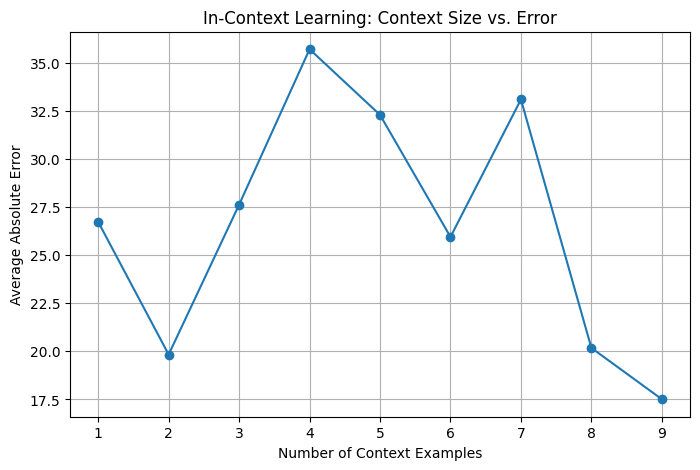

In [38]:
context_sizes = list(range(1, max_num_context + 1))
errors = []
for c in context_sizes:
    print("Evaluating for Context Size =", c)
    print("=" * 50)
    error = evaluate_context_size_error(num_context=c)
    if error is None:
        error = float('nan')
    errors.append(error)
    print("  Average absolute error: {:.4f}".format(error))

plt.figure(figsize=(8, 5))
plt.plot(context_sizes, errors, marker='o')
plt.xlabel("Number of Context Examples")
plt.ylabel("Average Absolute Error")
plt.title("In-Context Learning: Context Size vs. Error")
plt.grid(True)
plt.show()